# Packages

In [1]:
#basic packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

#data pre-processing packages
import tarfile
import urllib
from datetime import datetime
from windrose import WindroseAxes
from matplotlib.cm import ScalarMappable
from pywaffle import Waffle

#results and analysis packages
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
#data-preparation packages
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# from astropy.table import QTable
# import astropy.units as u

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from yellowbrick.regressor import PredictionError, ResidualsPlot

from scipy import stats

#linear models packages
from sklearn.linear_model import LinearRegression


# Script

## CONTROL

In [3]:
def control_AEP (IEC, Target, Target_gen, General, General_tun, XGB, XGB_without, AD1, power_curve, ref_air_density):

    #Air density normalization
    IEC1=air_density_norm(IEC, AD1, ref_air_density)
    General1=air_density_norm(General, AD1, ref_air_density)
    General_tun1=air_density_norm(General_tun, AD1, ref_air_density)
    XGB1=air_density_norm(XGB, AD1, ref_air_density)
    XGB_without1=air_density_norm(XGB_without, AD1, ref_air_density)
    Target1=air_density_norm2(Target, AD1, ref_air_density)
    Target_gen1=air_density_norm2(Target_gen, AD1, ref_air_density)
    
    
    #power compuration
    Power=powercurve_computation(Target1, power_curve)
    Power_gen=powercurve_computation(Target_gen1, power_curve)
    
    #Joining WS_pred with Power
    IEC2=IEC1.copy()
    IEC2['P']=Power['P'].copy()
    General2=General1.copy()
    General2['P']=Power_gen['P'].copy()
    General_tun2=General_tun1.copy()
    General_tun2['P']=Power_gen['P'].copy()
    XGB2=XGB1.copy()
    XGB2['P']=Power['P'].copy()
    XGB_without2=XGB_without1.copy()
    XGB_without2['P']=Power['P'].copy()
    
    #AEP computation
    AEP_table_IEC=AEP_computation(IEC2, power_curve)
    AEP_table_General=AEP_computation(General2, power_curve)
    AEP_table_General_tun=AEP_computation(General_tun2, power_curve)
    AEP_table_XGB=AEP_computation(XGB2, power_curve)
    AEP_table_XGB_without=AEP_computation(XGB_without2, power_curve)

    #AEP plot
    AEP_plot(AEP_table_IEC, AEP_table_General, AEP_table_General_tun, AEP_table_XGB, AEP_table_XGB_without)
    
    #AEP metrics
    perc_IEC, diff_IEC=AEP_metrics(AEP_table_IEC)
    perc_General, diff_General=AEP_metrics(AEP_table_General)
    perc_General_tun, diff_General_tun=AEP_metrics(AEP_table_General_tun)
    perc_XGB, diff_XGB=AEP_metrics(AEP_table_XGB)
    perc_XGB_without, diff_XGB_without=AEP_metrics(AEP_table_XGB_without)
    
    #AEP summary
    data={'AEP_perc':[perc_IEC, perc_General, perc_General_tun, perc_XGB, perc_XGB_without], 'AEP_diff':[diff_IEC, diff_General, diff_General_tun, diff_XGB, diff_XGB_without]}
    
    AEP_summary=pd.DataFrame(data,index=['IEC', 'Universal without tuning', 'Universal', 'Individual', 'Individual without tuning'])
    
    print(AEP_summary)
    
    
    return AEP_summary

In [4]:
def control_AEP_IEC (IEC, Target, AD1, power_curve, ref_air_density):

    #Air density normalization
    IEC1=air_density_norm(IEC, AD1, ref_air_density)
    Target1=air_density_norm2(Target, AD1, ref_air_density)
    
    #power compuration
    Power=powercurve_computation(Target1, power_curve)
    
    #Joining WS_pred with Power
    IEC2=IEC1.copy()
    IEC2['P']=Power['P'].copy()
    
    #AEP computation
    AEP_table_IEC=AEP_computation(IEC2, power_curve)

    #AEP plot
    AEP_plot_IEC(AEP_table_IEC, IEC2)
    
    #AEP metrics
    perc_IEC, diff_IEC=AEP_metrics(AEP_table_IEC)
    
    #AEP summary
    data={'AEP_perc':[perc_IEC], 'AEP_diff':[diff_IEC]}
    
    AEP_summary=pd.DataFrame(data,index=['IEC'])
    
    print(AEP_summary)
    
    
    return AEP_summary

In [5]:
def control_AEP_scatter (IEC, Target, LR, ANN, XGB, AD1, power_curve, ref_air_density):

    #Air density normalization
    IEC1=air_density_norm(IEC, AD1, ref_air_density)
    LR1=air_density_norm(LR, AD1, ref_air_density)
    ANN1=air_density_norm(ANN, AD1, ref_air_density)
    XGB1=air_density_norm(XGB, AD1, ref_air_density)
    Target1=air_density_norm2(Target, AD1, ref_air_density)
    
    #power compuration
    Power=powercurve_computation(Target1, power_curve)
    
    
    #Joining WS_pred with Power
    IEC2=IEC1.copy()
    IEC2['P']=Power['P'].copy()
    LR2=LR1.copy()
    LR2['P']=Power['P'].copy()
    ANN2=ANN1.copy()
    ANN2['P']=Power['P'].copy()
    XGB2=XGB1.copy()
    XGB2['P']=Power['P'].copy()
    
    #AEP computation
    AEP_table_IEC=AEP_computation(IEC2, power_curve)
    

    #AEP plot
    AEP_plot_scatter(AEP_table_IEC, IEC2, LR2, ANN2, XGB2)
    
    
    return print('scatter plot printed')

In [6]:
def control_AEP_scatter_avg (IEC, Target, Target_gen, General, General_tun, XGB, XGB_without, AD1, power_curve, ref_air_density):

    #Air density normalization
    IEC1=air_density_norm(IEC, AD1, ref_air_density)
    General1=air_density_norm(General, AD1, ref_air_density)
    General_tun1=air_density_norm(General_tun, AD1, ref_air_density)
    XGB1=air_density_norm(XGB, AD1, ref_air_density)
    XGB_without1=air_density_norm(XGB_without, AD1, ref_air_density)
    Target1=air_density_norm2(Target, AD1, ref_air_density)
    Target_gen1=air_density_norm2(Target_gen, AD1, ref_air_density)
    
    #power compuration
    Power=powercurve_computation(Target1, power_curve)
    Power_gen=powercurve_computation(Target_gen1, power_curve)
    
    #Joining WS_pred with Power
    IEC2=IEC1.copy()
    IEC2['P']=Power['P'].copy()
    General2=General1.copy()
    General2['P']=Power_gen['P'].copy()
    General_tun2=General_tun1.copy()
    General_tun2['P']=Power_gen['P'].copy()
    XGB2=XGB1.copy()
    XGB2['P']=Power['P'].copy()
    XGB_without2=XGB_without1.copy()
    XGB_without2['P']=Power['P'].copy()
    
    #AEP computation
    AEP_table_IEC=AEP_computation(IEC2, power_curve)
    AEP_table_General=AEP_computation(General2, power_curve)
    AEP_table_General_tun=AEP_computation(General_tun2, power_curve)
    AEP_table_XGB=AEP_computation(XGB2, power_curve)
    AEP_table_XGB_without=AEP_computation(XGB_without2, power_curve)

    #AEP plot
    AEP_plot_scatter_avg(AEP_table_IEC, AEP_table_General, AEP_table_General_tun, AEP_table_XGB, AEP_table_XGB_without, IEC2, General2, General_tun2, XGB2, XGB_without2)
    
    #AEP metrics
    perc_IEC, diff_IEC=AEP_metrics(AEP_table_IEC)
    perc_General, diff_General=AEP_metrics(AEP_table_General)
    perc_General_tun, diff_General_tun=AEP_metrics(AEP_table_General_tun)
    perc_XGB, diff_XGB=AEP_metrics(AEP_table_XGB)
    perc_XGB_without, diff_XGB_without=AEP_metrics(AEP_table_XGB_without)
    
    #AEP summary
    data={'AEP_perc':[perc_IEC, perc_General, perc_General_tun, perc_XGB, perc_XGB_without], 'AEP_diff':[diff_IEC, diff_General, diff_General_tun, diff_XGB, diff_XGB_without]}
    
    AEP_summary=pd.DataFrame(data,index=['IEC', 'Universal without tuning', 'Universal', 'Individual', 'Individual without tuning'])
    
    print(AEP_summary)
    
    
    return AEP_summary

## Air density normalization

In [7]:
def air_density_norm(WS_pred, AD1, ref_air_density):
    
    data=WS_pred.copy()
    data['AD1']=AD1.copy()
    
    
    #this function computes the wind speed corrected through the air density normalization
    #data is a dataframe with WS_pred and AD1 columns
    #ref_air_density is a value
    #this function return data2 dataframe with column WS_pred which is the corrected wind speed through normalization
    
    for i in data.index:
        data.at[i, 'WS_pred_corr']=data.at[i, 'WS_pred']*(data.at[i, 'AD1']/ref_air_density)**(1/3)

    data2=data.copy()
    data2=data2.drop(columns=['WS_pred', 'AD1'])
    data2=data2.rename(columns={'WS_pred_corr':'WS_pred'})
    

    return data2

In [8]:
def air_density_norm2(Target, AD1, ref_air_density):
    
    data=Target.copy()
    data['AD1']=AD1.copy()
    
    
    #this function computes the wind speed corrected through the air density normalization
    #data is a dataframe with WS_pred and AD1 columns
    #ref_air_density is a value
    #this function return data2 dataframe with column WS_pred which is the corrected wind speed through normalization
    
    for i in data.index:
        data.at[i, 'Target_corr']=data.at[i, 'Target']*(data.at[i, 'AD1']/ref_air_density)**(1/3)

    data2=data.copy()
    data2=data2.drop(columns=['Target', 'AD1'])
    data2=data2.rename(columns={'Target_corr':'Target'})
    

    return data2

## Power & AEP computation

In [9]:
def powercurve_computation(data, power_curve):
    
    from scipy import interpolate
    
    #this function computes the power at a observation given the information at a observation:
    # the WS (in m/s) at the wind turbine location and at the hub height (Target)
    # data is a dataframe with column Target
    # the power curve of the wind turbine in an xslx, with columns Wind Speed [m/s] and Warranted Power Curve [kW]
    # the output is data dataframe with columns Target and P
    
    if 'Wind Speed [m/s]' in power_curve.keys():
        x=power_curve['Wind Speed [m/s]']
    else:
        x=power_curve.index
    y=power_curve['Warranted Power Curve [kW]']
    x_new=data['Target']
    
    f = interpolate.interp1d(x, y)
    #, kind='linear'
    data['P']=f(x_new)

    return data

In [10]:
def AEP_computation(data, power_curve1):
    
    #this function computes the MPC_SC that will later be plotted
    #data is a dataframe with WS_pred and P columns
    #power_curve1 is just the power curve of the wind turbine
    #the output of this function is AEP_table dataframe with index: WS (the bins) and columns: WPC, MPC_SC, WAEP, MAEP_SC
    
    #binning the WS_Pred unit and 0.5-centered
    data['WS_pred_bin']=pd.cut(data['WS_pred'],
                                       bins=list(np.arange(-0.25,28.0,0.5)),
                                                 labels=list(np.arange(0.0,28.0,0.5)))

        
    #creating the AEP (Annual Energy Production table)
    power_curve=power_curve1.copy()
    power_curve.set_index('Wind Speed [m/s]', inplace=True)
        
    AEP_table=pd.DataFrame()
    
    AEP_table['WS']=power_curve.index
    AEP_table.set_index('WS', inplace=True)
    AEP_table['WPC']=power_curve['Warranted Power Curve [kW]']   
    AEP_table['MPC_SC']=data.groupby('WS_pred_bin', as_index=True)['P'].mean()

    
    AEP_table['WSAD']=power_curve['Wind Speed Distribution [Hr/Year]']
    
    #o igual aquí tendría que cortar la tabla para NaN values
    
    AEP_table=AEP_table.dropna()
    
    AEP_table['WAEP']=AEP_table['WPC']*AEP_table['WSAD']
    AEP_table['MAEP_SC']=AEP_table['MPC_SC']*AEP_table['WSAD']
    
    
    return AEP_table

## Plots and tables

In [11]:
################### AEP PLOT

def AEP_plot(AEP_table_IEC, AEP_table_General, AEP_table_General_tun, AEP_table_XGB, AEP_table_XGB_without):
    
    #AEP_table is expected to contain: WS in index and columns: WPC, MPC-SC

    #plotting the Power curves
    plt.figure(figsize=(10,8))
    plt.plot(AEP_table_IEC.index, AEP_table_IEC['MPC_SC'], marker='o', color='red', linewidth=0.5, label='IEC SC-PC', markersize=5, alpha=1)
    plt.plot(AEP_table_IEC.index, AEP_table_IEC['WPC'], marker='o', color='black', linewidth=0.5, label='WPC', markersize=5, alpha=1)
    plt.plot(AEP_table_General.index, AEP_table_General['MPC_SC'], marker='o', color='blue', linewidth=0.5, label='Universal without tuning SC-PC', markersize=5, alpha=1)
    plt.plot(AEP_table_General_tun.index, AEP_table_General_tun['MPC_SC'], marker='o', color='orange', linewidth=0.5, label='Universal SC-PC', markersize=5, alpha=1)
    plt.plot(AEP_table_XGB.index, AEP_table_XGB['MPC_SC'], marker='o', color='green', linewidth=0.5, label='Individual SC-PC', markersize=5, alpha=1)
    plt.plot(AEP_table_XGB_without.index, AEP_table_XGB_without['MPC_SC'], marker='o', color='pink', linewidth=0.5, label='Individual without tuning SC-PC', markersize=5, alpha=1)
    

    plt.legend(fontsize=12)

    ax=plt.gca()
    ax.set(ylabel='Power interpolated with WPC and Target WS (kW)', xlabel='Predicted Wind Speed (m/s)');
    ax.set_title('Site Calibration- Power Curve')
    #ax.set_xlim(xmin=9, xmax=11)
    ax.set_xlim(xmin=4, xmax=13)
    #ax.set_ylim(ymin=3000, ymax=3500)
    #ax.set_xlim(xmin=4, xmax=15)
    
    return print('Error plot performed')

In [12]:
################### AEP PLOT IEC only

def AEP_plot_IEC(AEP_table_IEC, data):
    
    #AEP_table is expected to contain: WS in index and columns: WPC, MPC-SC
    #data is expected to contain the columns: WS_pred, P by observations (this is plot as scatter)

    #plotting the Power curves
    plt.figure(figsize=(10,8))
    plt.plot(data['WS_pred'], data['P'], marker='o', ls='', label='measured scatter', markersize=5, alpha=.2)
    plt.plot(AEP_table_IEC.index, AEP_table_IEC['MPC_SC'], marker='o', color='red', linewidth=0.5, label='IEC SC-MPC', markersize=5, alpha=1)
    plt.plot(AEP_table_IEC.index, AEP_table_IEC['WPC'], marker='o', color='black', linewidth=0.5, label='WPC', markersize=5, alpha=1)


    plt.legend(fontsize=12)

    ax=plt.gca()
    ax.set(ylabel='Power interpolated with WPC and Target wind speed (kW)', xlabel='Predicted Wind Speed based on FCFs (m/s)');
    ax.set_title('Site Calibration- Power Curve based on IEC')
    #ax.set_xlim(xmin=9, xmax=11)
    ax.set_xlim(xmin=4, xmax=13)
    #ax.set_ylim(ymin=3000, ymax=3500)
    #ax.set_xlim(xmin=4, xmax=15)
    
    return print('Error plot performed')

In [13]:
################### AEP PLOT for the different scatters

def AEP_plot_scatter(AEP_table_IEC, IEC2, LR2, ANN2, XGB2):
    
    #datas are expected to contain the columns: WS_pred, P by observations (this is plot as scatter)

    #plotting the Power curves
    plt.figure(figsize=(10,8))
    #plt.plot(IEC2['WS_pred'], IEC2['P'], marker='o', ls='', color='red', label='IEC scatter', markersize=5, alpha=.2)
    #plt.plot(LR2['WS_pred'], LR2['P'], marker='o', ls='', color='red', label='LR scatter', markersize=5, alpha=.2)
    #plt.plot(ANN2['WS_pred'], ANN2['P'], marker='o', ls='', color='blue', label='ANN scatter', markersize=5, alpha=.2)
    plt.plot(XGB2['WS_pred'], XGB2['P'], marker='o', ls='', color='green', label='XGB scatter', markersize=5, alpha=.2)
    plt.plot(AEP_table_IEC.index, AEP_table_IEC['WPC'], marker='o', color='black', linewidth=0.5, label='WPC', markersize=5, alpha=1)

    plt.legend(fontsize=12)

    ax=plt.gca()
    ax.set(ylabel='Power interpolated with WPC and Target wind speed (kW)', xlabel='Predicted Wind Speed (m/s)');
    ax.set_title('Site Calibration- Power Curve scatter comparison')
    #ax.set_xlim(xmin=9, xmax=11)
    ax.set_xlim(xmin=4, xmax=13)
    #ax.set_ylim(ymin=3000, ymax=3500)
    #ax.set_xlim(xmin=4, xmax=15)
    
    return print('Error plot performed')

### scatter plot

In [69]:
################### AEP PLOT for the different scatters

def AEP_plot_scatter_avg(AEP_table_IEC, AEP_table_General, AEP_table_General_tun, AEP_table_XGB, AEP_table_XGB_without, IEC2, General2, General_tun2, XGB2, XGB_without2):

    
    #datas are expected to contain the columns: WS_pred, P by observations (this is plot as scatter)
    #AEP_table is expected to contain: WS in index and columns: WPC, MPC-SC

    #plotting the Power curves
    plt.figure(figsize=(10,8))
    #plt.plot(XGB_without2['WS_pred'], XGB_without2['P'], marker='o', ls='', color='blue', label='Individual without tuning scatter', markersize=5, alpha=.1)
    #plt.plot(XGB2['WS_pred'], XGB2['P'], marker='o', ls='', color='green', label='Individual scatter', markersize=5, alpha=.1)
    plt.plot(General2['WS_pred'], General2['P'], marker='o', ls='', color='blue', label='Universal scatter', markersize=5, alpha=.1)
    plt.plot(AEP_table_IEC.index, AEP_table_IEC['MPC_SC'], marker='o', color='red', linewidth=0.5, label='IEC SC-MPC', markersize=5, alpha=1)
    plt.plot(AEP_table_IEC.index, AEP_table_IEC['WPC'], marker='o', color='black', linewidth=0.5, label='WPC', markersize=5, alpha=1)
    #plt.plot(AEP_table_XGB_without.index, AEP_table_XGB_without['MPC_SC'], marker='o', color='blue', linewidth=0.5, label='Individual without tuning SC-MPC', markersize=5, alpha=1)
    #plt.plot(AEP_table_XGB.index, AEP_table_XGB['MPC_SC'], marker='o', color='green', linewidth=0.5, label='Individual SC-MPC', markersize=5, alpha=1)
    plt.plot(AEP_table_General.index, AEP_table_General['MPC_SC'], marker='o', color='blue', linewidth=0.5, label='Universal SC-MPC', markersize=5, alpha=1)

    

    plt.legend(fontsize=12)

    ax=plt.gca()
    ax.set(ylabel='Power interpolated with WPC and Target wind speed (kW)', xlabel='Predicted Wind Speed (m/s)');
    ax.set_title('Site Calibration- Power Curve comparison')
    #ax.set_xlim(xmin=9, xmax=11)
    ax.set_xlim(xmin=4, xmax=13)
    #ax.set_ylim(ymin=3000, ymax=3500)
    #ax.set_xlim(xmin=4, xmax=15)
    
    return print('Error plot performed')

In [17]:
################### AEP metrics

def AEP_metrics (AEP_table):

    #computing the metrics for later printing
    AEP_table2=pd.DataFrame(columns=AEP_table.columns)
    
    for i in AEP_table.index:
        if i>=3 and i<=15.5:
            AEP_table2.loc[i]=AEP_table.loc[i]
            
    
    #o igual aquí tendría que cortar la tabla para NaN values
    
    MAEP_SC=AEP_table2['MAEP_SC'].sum()
    WAEP=AEP_table2['WAEP'].sum()
    AEP_perc=(MAEP_SC/WAEP)*100
    AEP_diff=(MAEP_SC-WAEP)/1000
    
    
    return AEP_perc, AEP_diff

In [18]:
######################## AEP TABLE DRAW

def AEP_table_draw(AEP_table):
    
    #AEP_table is expected to contain: WPC, MPC_SC, WPC, WSAD, WAEP, MAEP_SC
    
    WS= AEP_table.index
    WPC=AEP_table['WPC']
    MPC=round(AEP_table['MPC_SC'],0)
    WSAD=AEP_table['WSAD']
    WAEP=round(AEP_table['WAEP']/1000000, 3)
    MAEP=round(AEP_table['MAEP_SC']/1000000, 3)
    
    row_headers=list(AEP_table.index)

    column_headers=('Wind speed bin (m/s)', 'WPC (kW)', 'MPC_SC (kW)',
                    'Annual Wind Distribution (h/year)', 'WAEP (GWh)', 'MAEP (GWh)')

    rcolors = plt.cm.BuPu(np.full(len(row_headers), 0.1))
    ccolors = plt.cm.BuPu(np.full(len(column_headers), 0.1))

    l_2d=[list(WS), list(WPC), list(MPC), list(WSAD), list(WAEP), list(MAEP)]

    cell_text=np.array(l_2d).T

    fig, ax = plt.subplots(figsize=(12,5)) 
    ax.set_axis_off()

    the_table=ax.table(cellText=cell_text,
                       rowLabels=row_headers,
                       rowColours=rcolors,
                       rowLoc='right',
                       colColours=ccolors,
                       colLabels=column_headers,
                       cellLoc ='center',
                       loc='upper center',
                       colWidths = [0.1] * 5)

    ax.set_title('Annual Energy Production for Site Calibration PC', 
                 fontweight ="bold", fontsize=14) 

    the_table.auto_set_font_size(False)
    the_table.set_fontsize(14)
    the_table.scale(2, 2)
    
    return ('AEP table printed')



# row_headers=index
#     column_headers=('Overall', 'Stratified', 'Random', 'Rand. %error', 'Strat. %error')
    
#     rcolors = plt.cm.BuPu(np.full(len(row_headers), 0.1))
#     ccolors = plt.cm.BuPu(np.full(len(column_headers), 0.1))
    
#     l_2d=[list(Overall), list(Stratified), list(Random), list(Rand_error), list(Strat_error)]
     
#     cell_text=np.array(l_2d).T
    
#     fig, ax = plt.subplots(figsize=(12,5)) 
#     ax.set_axis_off()
    
#     the_table=ax.table(cellText=cell_text,
#                       rowLabels=row_headers,
#                       rowColours=rcolors,
#                       rowLoc='right',
#                       colColours=ccolors,
#                       colLabels=column_headers,
#                       cellLoc ='center',
#                       loc='upper center',
#                       colWidths = [0.1] * 5)

In [19]:
def power_plot(data, title):
    
    #title is expected to be an str
    #WS_pred and Target should be the variables names

    #plotting the reference
    plt.figure(figsize=(12,8))
    plt.plot(data['Target'], data['P'], marker='o', ls='', label='Power curve', markersize=5, alpha=.1)


    plt.legend()

    ax=plt.gca()
    ax.set(xlabel='Target wind speed (m/s)', ylabel='Power computed (kW)');
    ax.set_title(title)
    
    return print('Error plot performed')

In [20]:
#reference data

def apply_reference(data, power_curve):
    
    #this function creates a reference dataFrame by using the IEC metholodogy
    #this function requires the WD_bins clustering
    #this function uses the following functions:
    # FCF_computation
    # FCF_application
    # 


    if 'WD_bin' not in data.keys():
        print('Wind direction bin clustering missing')
        

    #applying the FCFs computed internally on FCF_application :
    if 'WS_pred' not in data.keys():
        data=FCF_application(data)
    
    if 'P_pred' not in data.keys():
        print('power_computation missing')

    print('IEC method errors:')
    df,AEP_table=errors_computation(data, power_curve)
    
    error_plot(data, 'IEC method regression with computed FCFs')

    
    return data,AEP_table

## Data uploading & saving

In [21]:
def uploading_csv(file_folder,file_name):
    
    #file folder required
    #file name required
    #file is expected to be in the data root: r'C:\Users\irgaa\Irma\Data'
    #this function uploads and formats csv/txt/xlsx datasets into DataFrame
    
    
    data_root=r'C:\Users\irgaa\Irma\Data'
    data_folder=str(file_folder)
    data_file=str(file_name)
    
    data_path=data_root+data_folder+data_file
    
    data1 = pd.read_csv(data_path)

    
    # We will save the WD_bin as the index
    
    return data1

In [22]:
#this function saves a data csv

def save (data, file_folder,file_name):
    
    #file folder required
    #file name required
    #file is expected to be saved in the data root: r'C:\Users\irgaa\Irma\Data'
    #this function saves a csv/txt/xlsx into Irma's folder
    #the saved file will keep the columns names but not the index
    
    data_root=r'C:\Users\irgaa\Irma\Data'
    data_folder=str(file_folder)
    data_file=str(file_name)
    
    data_path=data_root+data_folder+data_file
    
    data.to_csv (data_path, index = False, header=True)
    
    
    return print('file', data_file, 'saved in', data_folder, 'folder')

# Data analysis

## Dataset1- WTG14

In [23]:
#upload the dataset with file_folder, file_name
IEC= uploading_csv('\Results_','IEC_WTG14.csv')
General=uploading_csv('\Results_','General_XGB_WTG14.csv')
General_tun=uploading_csv('\Results_','General_tun_XGB_WTG14.csv')
XGB=uploading_csv('\Results_','XGB_WTG14.csv')
XGB_without=uploading_csv('\Results_','UnivHyper_XGB_WTG14.csv')
Target=uploading_csv('\y_','test14.csv')
Target_gen=uploading_csv('\General','\y_test14.csv')
AD1=uploading_csv('\Results_','AD1_WTG14.csv')

In [24]:
ref_air_density=1.15
power_curve=uploading_csv('\Dataset1-Normal_Site','\PC_1.15kgm-3.csv')

Error plot performed
                             AEP_perc    AEP_diff
IEC                         99.172870 -118.417440
Universal without tuning   101.793472  258.069323
Universal                  102.556973  368.788706
Individual                 100.085068   12.240789
Individual without tuning  100.009935    1.429517


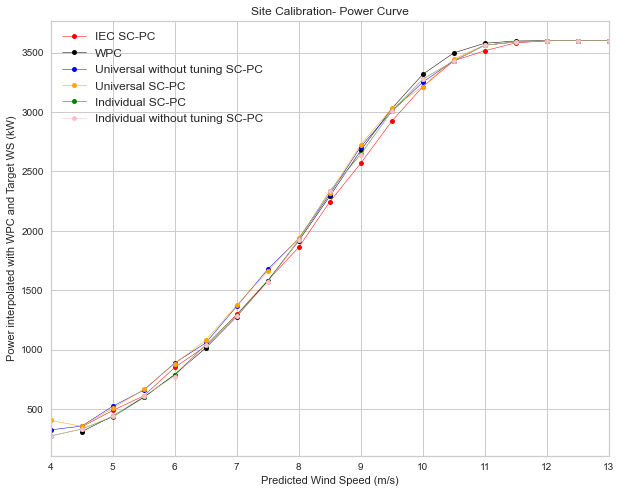

In [27]:
AEP_summary=control_AEP (IEC, Target, Target_gen, General, General_tun, XGB, XGB_without, AD1, power_curve, ref_air_density)

Error plot performed
                             AEP_perc    AEP_diff
IEC                         99.172870 -118.417440
Universal without tuning   101.793472  258.069323
Universal                  102.556973  368.788706
Individual                 100.085068   12.240789
Individual without tuning  100.009935    1.429517


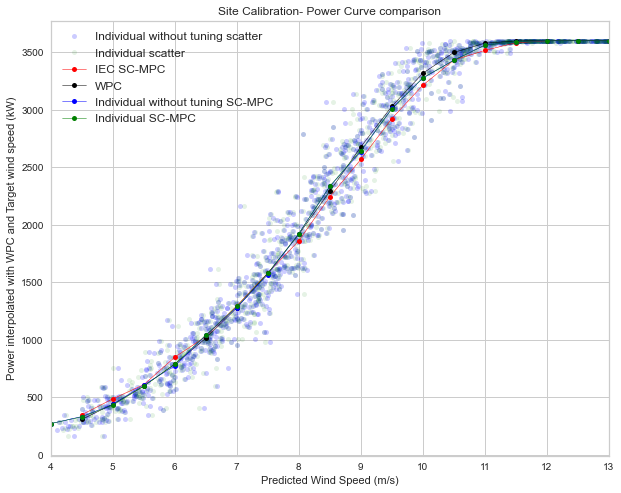

In [25]:
AEP_summary=control_AEP_scatter_avg (IEC, Target, Target_gen, General, General_tun, XGB, XGB_without, AD1, power_curve, ref_air_density)

Error plot performed
                             AEP_perc    AEP_diff
IEC                         99.172870 -118.417440
Universal without tuning   101.793472  258.069323
Universal                  102.556973  368.788706
Individual                 100.085068   12.240789
Individual without tuning  100.009935    1.429517


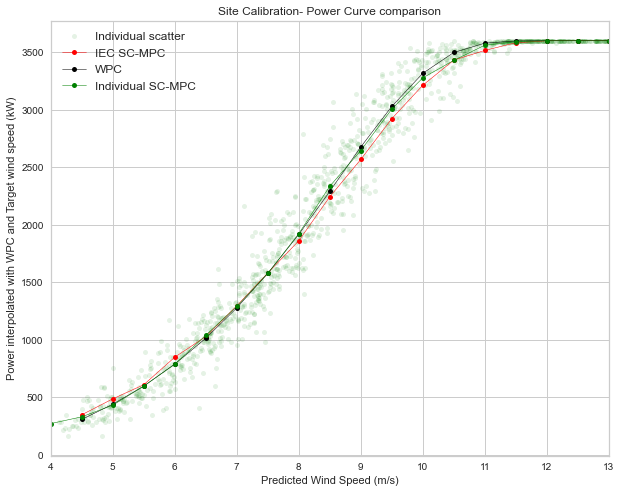

In [27]:
AEP_summary=control_AEP_scatter_avg (IEC, Target, Target_gen, General, General_tun, XGB, XGB_without, AD1, power_curve, ref_air_density)

Error plot performed
                             AEP_perc    AEP_diff
IEC                         99.172870 -118.417440
Universal without tuning   101.793472  258.069323
Universal                  102.556973  368.788706
Individual                 100.085068   12.240789
Individual without tuning  100.009935    1.429517


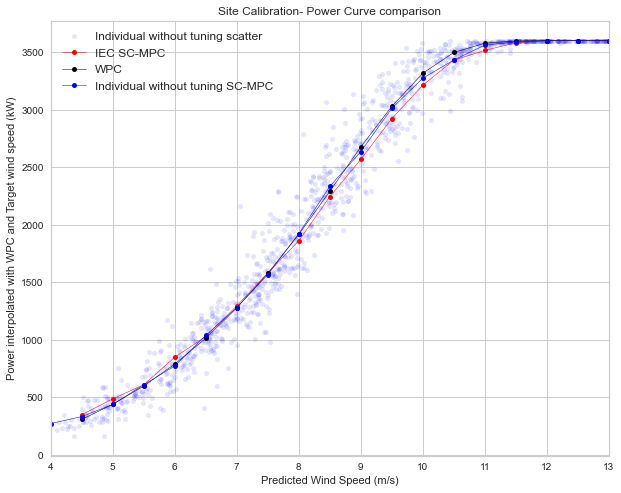

In [31]:
AEP_summary=control_AEP_scatter_avg (IEC, Target, Target_gen, General, General_tun, XGB, XGB_without, AD1, power_curve, ref_air_density)

## Dataset1- WTG15

In [48]:
#upload the dataset with file_folder, file_name
IEC= uploading_csv('\Results_','IEC_WTG15.csv')
General=uploading_csv('\Results_','General_XGB_WTG15.csv')
General_tun=uploading_csv('\Results_','General_tun_XGB_WTG15.csv')
XGB_without=uploading_csv('\Results_','UnivHyper_XGB_WTG15.csv')
XGB=uploading_csv('\Results_','XGB_WTG15.csv')
Target=uploading_csv('\y_','test15.csv')
Target_gen=uploading_csv('\General','\y_test15.csv')
AD1=uploading_csv('\Results_','AD1_WTG15.csv')

In [49]:
ref_air_density=1.15
power_curve=uploading_csv('\Dataset1-Normal_Site','\PC_1.15kgm-3.csv')

Error plot performed
                            AEP_perc    AEP_diff
IEC                        99.215449 -112.891997
Universal without tuning   99.323878  -97.516228
Universal                  99.875575  -17.955400
Individual                 99.292763 -102.003858
Individual without tuning  99.311588  -99.058065


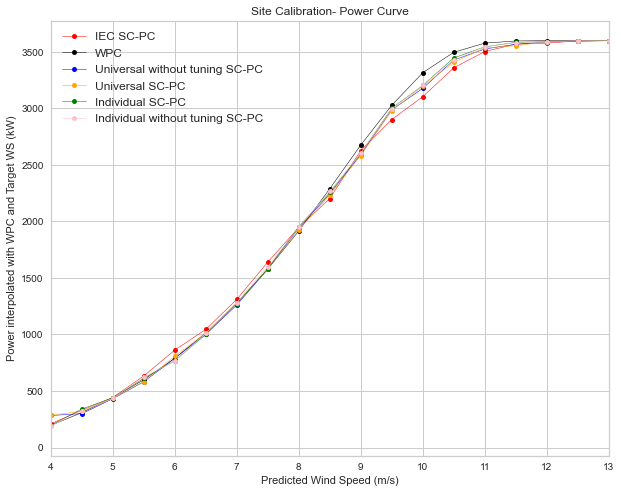

In [31]:
AEP_summary=control_AEP (IEC, Target, Target_gen, General, General_tun, XGB, XGB_without, AD1, power_curve, ref_air_density)

Error plot performed
                            AEP_perc    AEP_diff
IEC                        99.215449 -112.891997
Universal without tuning   99.323878  -97.516228
Universal                  99.875575  -17.955400
Individual                 99.292763 -102.003858
Individual without tuning  99.311588  -99.058065


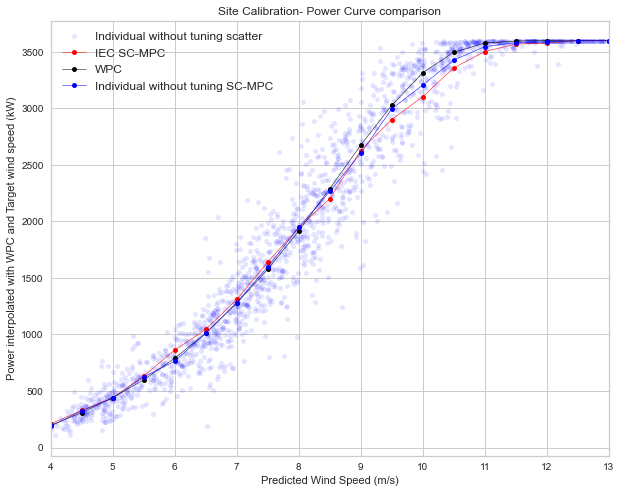

In [34]:
AEP_summary=control_AEP_scatter_avg (IEC, Target, Target_gen, General, General_tun, XGB, XGB_without, AD1, power_curve, ref_air_density)

Error plot performed
                            AEP_perc    AEP_diff
IEC                        99.215449 -112.891997
Universal without tuning   99.323878  -97.516228
Universal                  99.875575  -17.955400
Individual                 99.292763 -102.003858
Individual without tuning  99.311588  -99.058065


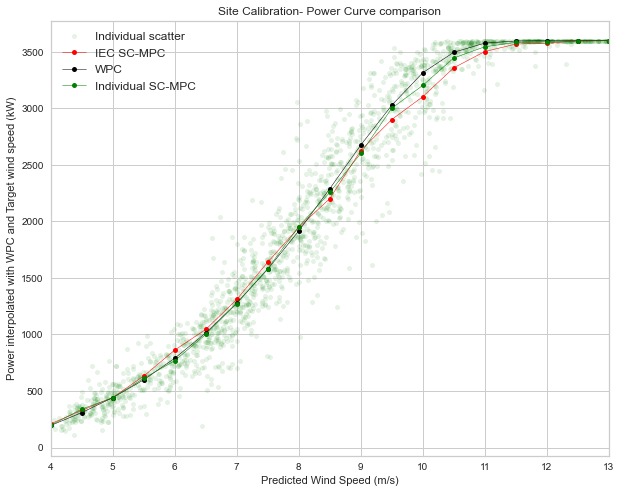

In [50]:
AEP_summary=control_AEP_scatter_avg (IEC, Target, Target_gen, General, General_tun, XGB, XGB_without, AD1, power_curve, ref_air_density)

## Dataset3- WTG18

In [51]:
#upload the dataset with file_folder, file_name
IEC= uploading_csv('\Results_','IEC_WTG18.csv')
General=uploading_csv('\Results_','General_XGB_WTG18.csv')
General_tun=uploading_csv('\Results_','General_tun_XGB_WTG18.csv')
XGB=uploading_csv('\Results_','XGB_WTG18.csv')
XGB_without=uploading_csv('\Results_','UnivHyper_XGB_WTG18.csv')
Target=uploading_csv('\y_','test18.csv')
Target_gen=uploading_csv('\General','\y_test18.csv')
AD1=uploading_csv('\Results_','AD1_WTG18.csv')

In [52]:
ref_air_density=1.175
power_curve=uploading_csv('\Dataset3-New_Site','\PC_V150.csv')

Error plot performed
                            AEP_perc   AEP_diff
IEC                        99.871834 -27.156810
Universal without tuning   99.907266 -19.680189
Universal                  99.796894 -43.035585
Individual                 99.869546 -27.685296
Individual without tuning  99.754331 -52.054113


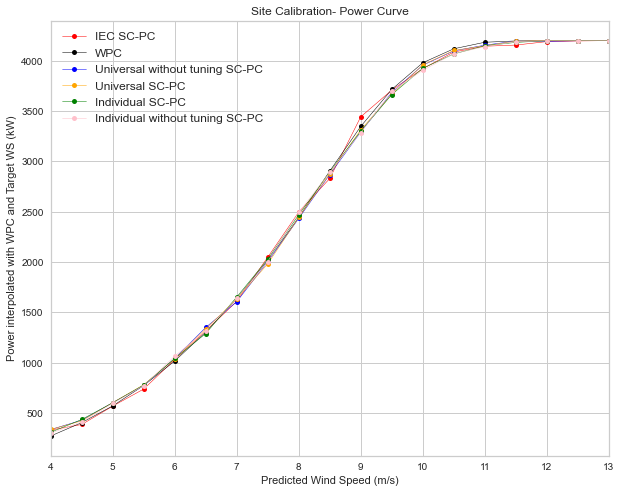

In [34]:
AEP_summary=control_AEP (IEC, Target, Target_gen, General, General_tun, XGB, XGB_without, AD1, power_curve, ref_air_density)

Error plot performed
                            AEP_perc   AEP_diff
IEC                        99.871834 -27.156810
Universal without tuning   99.907266 -19.680189
Universal                  99.796894 -43.035585
Individual                 99.869546 -27.685296
Individual without tuning  99.754331 -52.054113


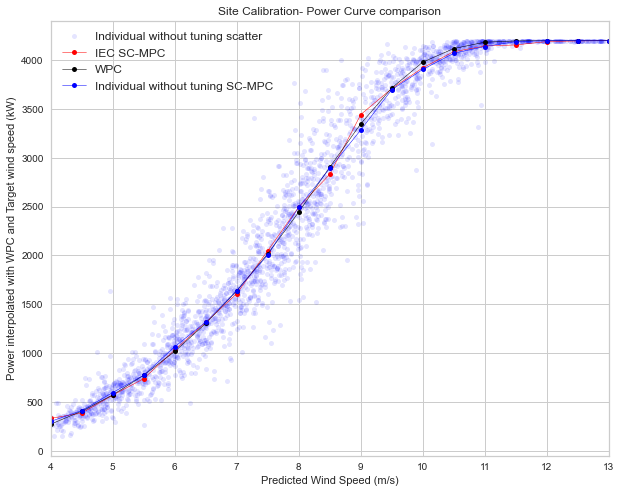

In [37]:
AEP_summary=control_AEP_scatter_avg (IEC, Target, Target_gen, General, General_tun, XGB, XGB_without, AD1, power_curve, ref_air_density)

Error plot performed
                            AEP_perc   AEP_diff
IEC                        99.871834 -27.156810
Universal without tuning   99.907266 -19.680189
Universal                  99.796894 -43.035585
Individual                 99.869546 -27.685296
Individual without tuning  99.754331 -52.054113


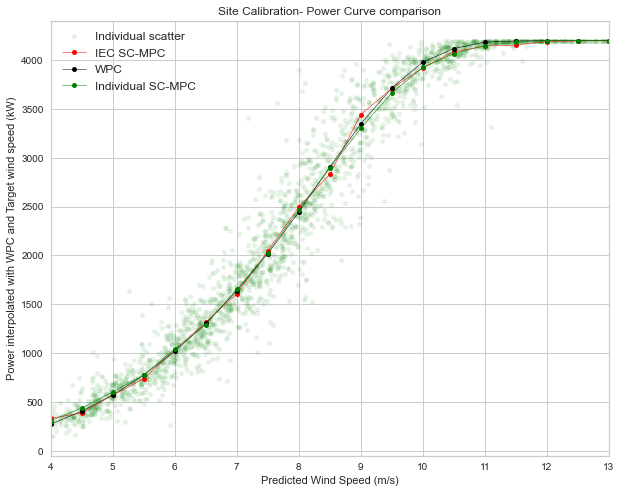

In [53]:
AEP_summary=control_AEP_scatter_avg (IEC, Target, Target_gen, General, General_tun, XGB, XGB_without, AD1, power_curve, ref_air_density)

## Dataset3- WTG20

In [71]:
#upload the dataset with file_folder, file_name
IEC= uploading_csv('\Results_','IEC_WTG20.csv')
General=uploading_csv('\Results_','General_XGB_WTG20.csv')
General_tun=uploading_csv('\Results_','General_tun_XGB_WTG20.csv')
XGB_without=uploading_csv('\Results_','UnivHyper_XGB_WTG20.csv')
XGB=uploading_csv('\Results_','XGB_WTG20.csv')
Target=uploading_csv('\y_','test20.csv')
Target_gen=uploading_csv('\General','\y_test20.csv')
AD1=uploading_csv('\Results_','AD1_WTG20.csv')

In [72]:
ref_air_density=1.175
power_curve=uploading_csv('\Dataset3-New_Site','\PC_V150.csv')

Error plot performed
                             AEP_perc   AEP_diff
IEC                        100.357501  75.065236
Universal without tuning    99.962126  -8.037733
Universal                  100.030450   6.393642
Individual                 100.058534  12.154434
Individual without tuning   99.866283 -27.721313


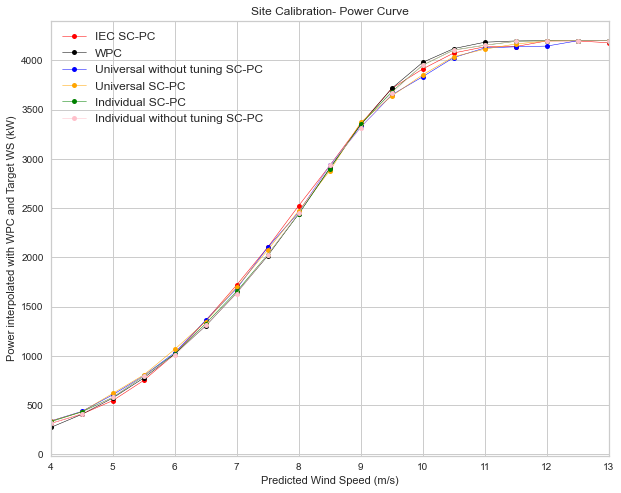

In [37]:
AEP_summary=control_AEP (IEC, Target, Target_gen, General, General_tun, XGB, XGB_without, AD1, power_curve, ref_air_density)

Error plot performed
                             AEP_perc   AEP_diff
IEC                        100.357501  75.065236
Universal without tuning    99.962126  -8.037733
Universal                  100.030450   6.393642
Individual                 100.058534  12.154434
Individual without tuning   99.866283 -27.721313


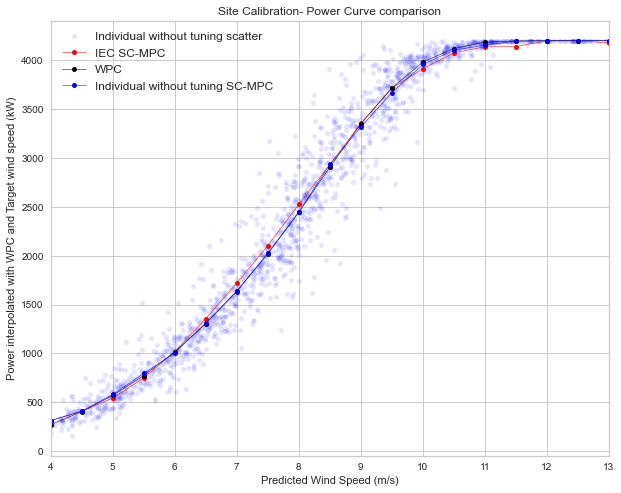

In [40]:
AEP_summary=control_AEP_scatter_avg (IEC, Target, Target_gen, General, General_tun, XGB, XGB_without, AD1, power_curve, ref_air_density)

Error plot performed
                             AEP_perc   AEP_diff
IEC                        100.357501  75.065236
Universal without tuning    99.962126  -8.037733
Universal                  100.030450   6.393642
Individual                 100.058534  12.154434
Individual without tuning   99.866283 -27.721313


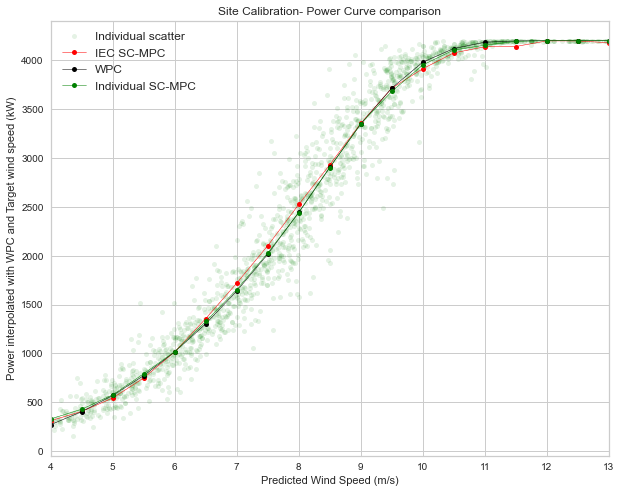

In [56]:
AEP_summary=control_AEP_scatter_avg (IEC, Target, Target_gen, General, General_tun, XGB, XGB_without, AD1, power_curve, ref_air_density)

Error plot performed
                             AEP_perc   AEP_diff
IEC                        100.357501  75.065236
Universal without tuning    99.962126  -8.037733
Universal                  100.030450   6.393642
Individual                 100.058534  12.154434
Individual without tuning   99.866283 -27.721313


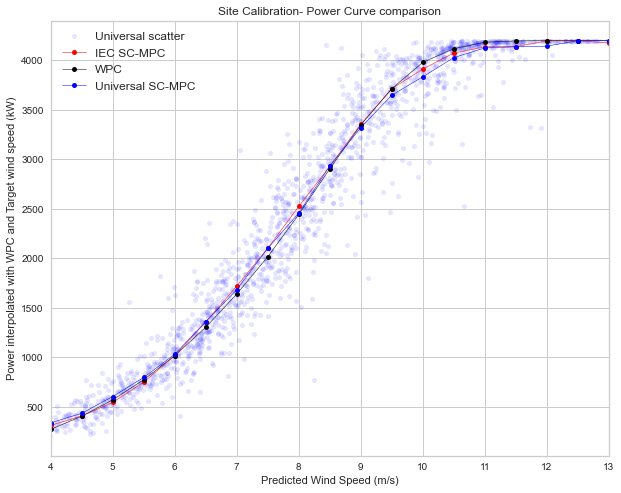

In [73]:
AEP_summary=control_AEP_scatter_avg (IEC, Target, Target_gen, General, General_tun, XGB, XGB_without, AD1, power_curve, ref_air_density)

## Dataset3- WTG43

In [57]:
#upload the dataset with file_folder, file_name
IEC= uploading_csv('\Results_','IEC_WTG43.csv')
General=uploading_csv('\Results_','General_XGB_WTG43.csv')
General_tun=uploading_csv('\Results_','General_tun_XGB_WTG43.csv')
XGB=uploading_csv('\Results_','XGB_WTG43.csv')
XGB_without=uploading_csv('\Results_','UnivHyper_XGB_WTG43.csv')
Target=uploading_csv('\y_','test43.csv')
Target_gen=uploading_csv('\General','\y_test43.csv')
AD1=uploading_csv('\Results_','AD1_WTG43.csv')

In [58]:
ref_air_density=1.175
power_curve=uploading_csv('\Dataset3-New_Site','\PC_V150.csv')

Error plot performed
                             AEP_perc    AEP_diff
IEC                        100.399747   84.422064
Universal without tuning   103.180640  675.004244
Universal                  102.769387  586.797828
Individual                  99.826054  -36.856951
Individual without tuning   99.682018  -67.376375


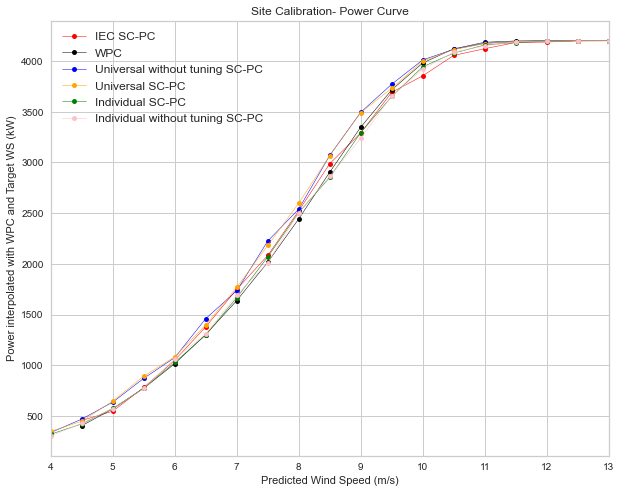

In [40]:
AEP_summary=control_AEP (IEC, Target, Target_gen, General, General_tun, XGB, XGB_without, AD1, power_curve, ref_air_density)

Error plot performed
                             AEP_perc    AEP_diff
IEC                        100.399747   84.422064
Universal without tuning   103.180640  675.004244
Universal                  102.769387  586.797828
Individual                  99.826054  -36.856951
Individual without tuning   99.682018  -67.376375


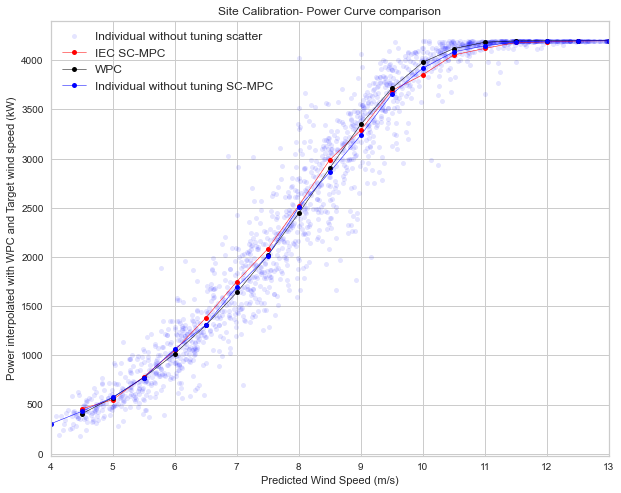

In [43]:
AEP_summary=control_AEP_scatter_avg (IEC, Target, Target_gen, General, General_tun, XGB, XGB_without, AD1, power_curve, ref_air_density)

Error plot performed
                             AEP_perc    AEP_diff
IEC                        100.399747   84.422064
Universal without tuning   103.180640  675.004244
Universal                  102.769387  586.797828
Individual                  99.826054  -36.856951
Individual without tuning   99.682018  -67.376375


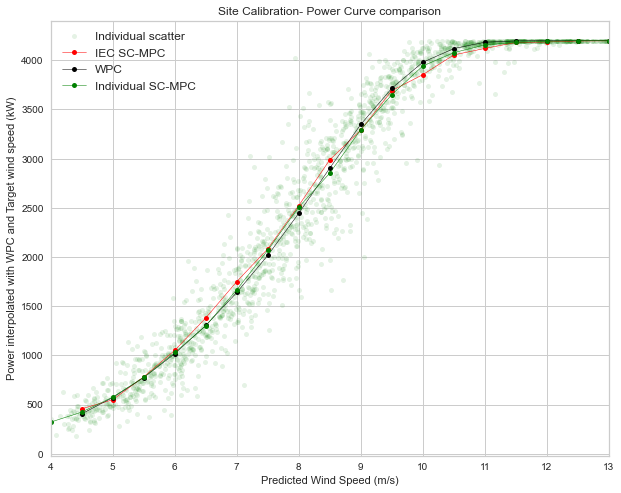

In [59]:
AEP_summary=control_AEP_scatter_avg (IEC, Target, Target_gen, General, General_tun, XGB, XGB_without, AD1, power_curve, ref_air_density)

## Dataset3- WTG46

In [64]:
#upload the dataset with file_folder, file_name
IEC= uploading_csv('\Results_','IEC_WTG46.csv')
General=uploading_csv('\Results_','General_XGB_WTG46.csv')
General_tun=uploading_csv('\Results_','General_tun_XGB_WTG46.csv')
XGB=uploading_csv('\Results_','XGB_WTG46.csv')
XGB_without=uploading_csv('\Results_','UnivHyper_XGB_WTG46.csv')
Target=uploading_csv('\y_','test46.csv')
Target_gen=uploading_csv('\General','\y_test46.csv')
AD1=uploading_csv('\Results_','AD1_WTG46.csv')

In [65]:
ref_air_density=1.175
power_curve=uploading_csv('\Dataset3-New_Site','\PC_V150.csv')

Error plot performed
                            AEP_perc    AEP_diff
IEC                        99.941403  -12.415893
Universal without tuning   96.282173 -789.007529
Universal                  96.379733 -768.302975
Individual                 99.980185   -4.205224
Individual without tuning  99.943176  -12.059323


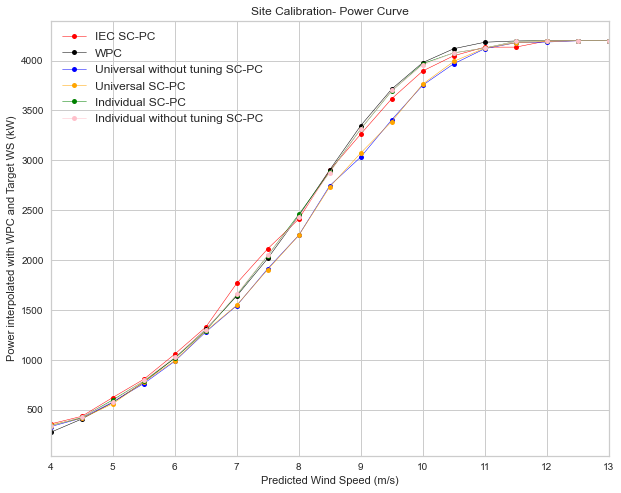

In [43]:
AEP_summary=control_AEP (IEC, Target, Target_gen, General, General_tun, XGB, XGB_without, AD1, power_curve, ref_air_density)

Error plot performed
                            AEP_perc    AEP_diff
IEC                        99.941403  -12.415893
Universal without tuning   96.282173 -789.007529
Universal                  96.379733 -768.302975
Individual                 99.980185   -4.205224
Individual without tuning  99.943176  -12.059323


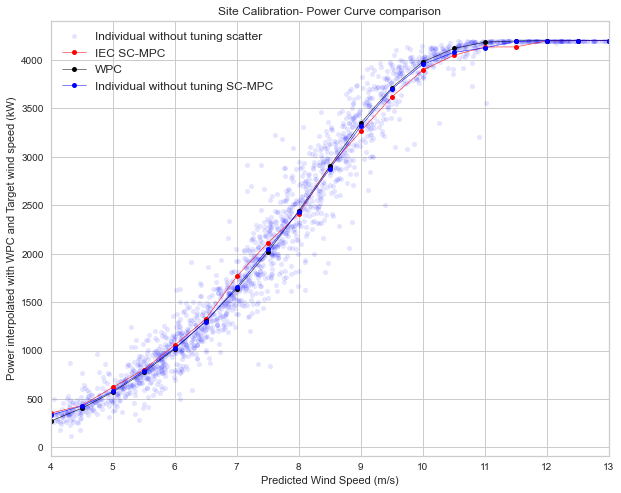

In [46]:
AEP_summary=control_AEP_scatter_avg (IEC, Target, Target_gen, General, General_tun, XGB, XGB_without, AD1, power_curve, ref_air_density)

Error plot performed
                            AEP_perc    AEP_diff
IEC                        99.941403  -12.415893
Universal without tuning   96.282173 -789.007529
Universal                  96.379733 -768.302975
Individual                 99.980185   -4.205224
Individual without tuning  99.943176  -12.059323


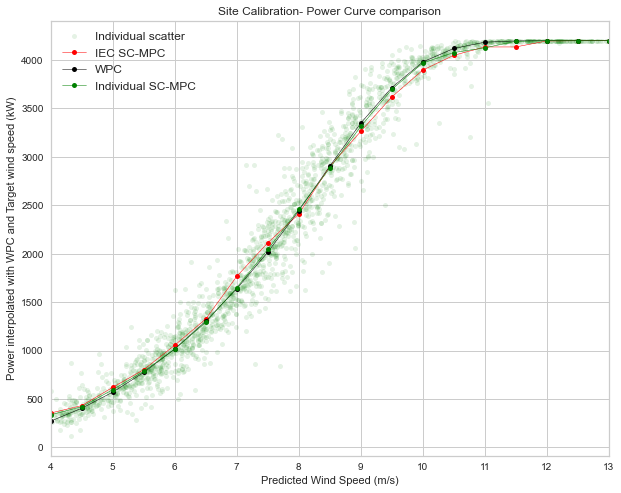

In [62]:
AEP_summary=control_AEP_scatter_avg (IEC, Target, Target_gen, General, General_tun, XGB, XGB_without, AD1, power_curve, ref_air_density)

Error plot performed
                            AEP_perc    AEP_diff
IEC                        99.941403  -12.415893
Universal without tuning   96.282173 -789.007529
Universal                  96.379733 -768.302975
Individual                 99.980185   -4.205224
Individual without tuning  99.943176  -12.059323


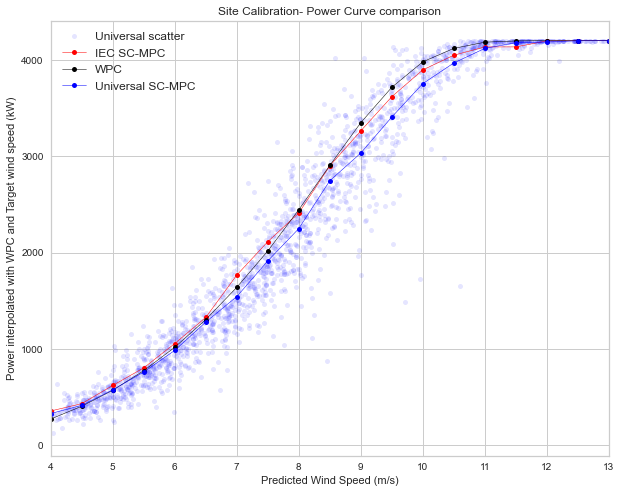

In [70]:
AEP_summary=control_AEP_scatter_avg (IEC, Target, Target_gen, General, General_tun, XGB, XGB_without, AD1, power_curve, ref_air_density)